# Notebook to make plots for figure 4

by Cascade Tuholske 2020.04.06

**Pick a city of geography & Year ... 1987-1988 W Africa, 1998 India & 2003 Europe** <br>
Cities : 12080 Hongcong, 9691 Kolkata, 8050 Bangalore, 1910 Accra, 2125 Lagos, 2046 Paris, 2987 Rome,
2559 Milan, 1887 bordeaux, 2135 Brussels, <br>

**We're using**
- 9691, Kolkata 1998
- 2046, Paris 2003
- 4417, Aleppo 2010

Helpful for julian days: https://landweb.modaps.eosdis.nasa.gov/browse/calendar.html

In [1]:
#### Dependencies
import glob
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import rcParams
import matplotlib.dates as mdates


In [2]:
#### Heat Index Data 
DATA_IN = '/home/cascade/projects/UrbanHeat/data/interim/ERA5_HI/' # output from avg temp
FIG_OUT = '/home/cascade/projects/UrbanHeat/figures/'
DS = u"\N{DEGREE SIGN}"

In [3]:
def make_data(dir_in, geog, location):
    """Function makes data to plot daily city-level HI Max and average
    Args:
        dir_in = directory to get data
        geog = column for geography, city-level = 'ID_HDC_G0'
        location = usually a city id
    """
    
    fn_list = sorted(glob.glob(dir_in+'*.csv')) # get data
    df_out = pd.DataFrame() # to write dataframe
    
     # get leap year cols from 2016
    hi16 = pd.read_csv(fn_list[33]) 
    cols = list(hi16.iloc[:,3:].columns)
    cols = [year[5:] for year in cols] # cols for data frame
    
    temp_list = [] # empty list for temps
    
    # loop through dir and get data
    for i, fn in enumerate(fn_list):
        df = pd.read_csv(fn) # open data frame
        year_label = [(df.columns[3]).split('.')[0]] # get year
        row = df[df[geog] == location]
        temp = row.iloc[:,3:] # get only temp columns
        
        # add in col for leap years
        if temp.shape[1] == 365:
            temp.insert(loc = 59, column = year_label[0]+'.02.29', value = np.nan, allow_duplicates=False)

        # Set Index & Columns
        temp.index = year_label
        temp.columns = cols # revalue to m.d
    
        # add to list
        temp_list.append(temp)
    
    df_out = pd.concat(temp_list) # make one big dataframe
    
    return df_out
    

In [4]:
def plot_data(df, year, start, end):#, start, end):
    """ Make the data for a plot
    Args: 
        df = df w/ daily HI max for a given city
        year = year you want to plot against average
        start = start of plot in julian days (e.g 1 - 365/366)
        end = end of plot in julian days
    """

    # Deal with leap year
    if year % 4 !=0:
        df.drop(columns ='02.29', inplace = True)
    
    # Subset data
    start = start - 1 # zero indexing 
    subset = df.iloc[:,start:end]
    
    # HI Max for year
    hi_year = subset.loc[str(year)]
    
    # make 34-avg daily hi
    means = subset.mean(axis = 0)
    
    # make colums to date time
    cols = pd.to_datetime([str(year)+'.'+date for date in hi_year.index])
    
    return hi_year, means, cols


# One panel

In [66]:
# Args
#[3342, 'Cairo'] #[1910, 'Accra'] 3268, Cape Town
#[4417, 'Aleppo'] [2046, 'Paris'] [9691, 'Kolkata'] 

city_list = [4417, 'Aleppo'] 
year = 2010
font_size = 9

# April 1 to Sep 30 (Use Julian Days), or 1 - 182 lagos
start = 91 
end = 273

# Labels
hi_label = str(year)+' HI'
labels =  ['avg. HI', hi_label, '40.6 '+DS+'C']

# Make Data 
data = make_data(DATA_IN, 'ID_HDC_G0', city_list[0])
hi_year, means,cols = plot_data(data, year, start, end)

# FN OUT
#FN_OUT = 'FIG4-Aleppo10.png'

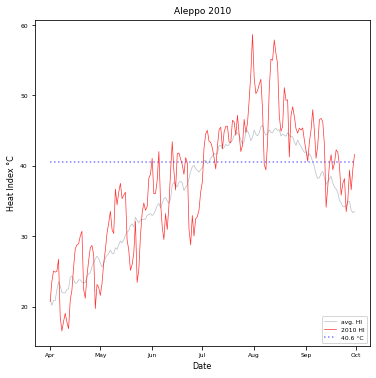

In [67]:
#### Make Figure & Save it

# Set up
rcParams['mathtext.default'] = 'regular' # set text to reg, not italic 
fig, axs = plt.subplots(1, 1, figsize = (6, 6), sharex=True) #(3, 2.247)
ws = 0.5
fig.subplots_adjust(hspace=ws)

#plot
axs.plot(cols, means, color = 'slategray', alpha = 0.5, linestyle = '-', lw = 0.7) # Long term daily avg
axs.plot(cols, hi_year, color = 'red', alpha = 0.8, lw = 0.7) # Daily HI Max
axs.hlines(y = 40.6, xmin = min(cols), xmax = max(cols), alpha = 0.5, linestyle = ':', color = 'blue')
axs.set_title(city_list[1]+' '+str(year), fontsize = font_size)
axs.tick_params(axis='both', labelsize = 6)

# ticks
# Make ticks on occurrences of each month:
axs.xaxis.set_major_locator(mdates.MonthLocator())
axs.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
axs.tick_params(axis='both', labelsize = 6)
#axs.xaxis.set_major_locator(plt.MaxNLocator(3))

# Labels
#fig.text(0,0.5, 'Heat Index '+DS+'C', ha="center", va="center", rotation=90, fontsize = 8)
plt.ylabel('Heat Index '+DS+'C', fontsize = 8)
plt.xlabel('Date', fontsize = 8)


# Legend
plt.legend(labels, loc=4, prop={'size': 6})

# Save it out
#plt.savefig(FIG_OUT+FN_OUT, dpi = 300, bbox_inches='tight')

In [68]:
#### Always double check dates are correct
cols

DatetimeIndex(['2010-04-01', '2010-04-02', '2010-04-03', '2010-04-04',
               '2010-04-05', '2010-04-06', '2010-04-07', '2010-04-08',
               '2010-04-09', '2010-04-10',
               ...
               '2010-09-21', '2010-09-22', '2010-09-23', '2010-09-24',
               '2010-09-25', '2010-09-26', '2010-09-27', '2010-09-28',
               '2010-09-29', '2010-09-30'],
              dtype='datetime64[ns]', length=183, freq=None)

#### Look at data

In [69]:
# Find Heat Wave From All DATA
def select_city_year(df, city_id, year):
    "Quick search to find city and years within HI_STATS"
    df_out = df[(df['ID_HDC_G0'] == city_id) & (df['year'] == year)]
    
    return df_out

meta_fn = '/home/cascade/projects/UrbanHeat/data/processed/AllDATA-GHS-ERA5-HI406-META.csv'
ALL_DATA = pd.read_csv(meta_fn)

# [4417, 'Aleppo'] [2046, 'Paris'] [9691, 'Kolkata'] 
city = select_city_year(ALL_DATA, 4417, 2010)
city

,Unnamed: 0,Unnamed: 0.1,ID_HDC_G0,CTR_MN_NM,total_days,duration,avg_temp,avg_intensity,tot_intensity,event_dates,intensity,tmax,year,Event_ID,region,sub-region,intermediate-region,GCPNT_LAT,GCPNT_LON
789211,789211,8398,4417,Syria,81,1,41.058449,0.458449,0.458449,['2010.06.01'],[0.45844907],[41.05844907],2010,4543192,Asia,Western Asia,Western Asia,36.204277,37.146243
789212,789212,8399,4417,Syria,81,1,42.030491,1.430491,1.430491,['2010.06.05'],[1.43049112],[42.03049112],2010,4543193,Asia,Western Asia,Western Asia,36.204277,37.146243
789213,789213,8400,4417,Syria,81,1,43.434740,2.834740,2.834740,['2010.06.13'],[2.83474009],[43.43474009],2010,4543194,Asia,Western Asia,Western Asia,36.204277,37.146243
789214,789214,8401,4417,Syria,81,3,41.509947,0.909947,2.729842,['2010.06.16' '2010.06.17' '2010.06.18'],[1.11513944 1.22099224 0.39370996],[41.71513944 41.82099224 40.99370996],2010,4543195,Asia,Western Asia,Western Asia,36.204277,37.146243
789215,789215,8402,4417,Syria,81,1,41.173751,0.573751,0.573751,['2010.06.21'],[0.57375059],[41.17375059],2010,4543196,Asia,Western Asia,Western Asia,36.204277,37.146243
789216,789216,8403,4417,Syria,81,7,43.234569,2.634569,18.441983,['2010.07.02' '2010.07.03' '2010.07.04' '2010....,[1.93268674 3.94627376 4.44213757 2.87889517 2...,[42.53268674 44.54627376 45.04213757 43.478895...,2010,4543197,Asia,Western Asia,Western Asia,36.204277,37.146243
789217,789217,8404,4417,Syria,81,28,47.005698,6.405698,179.359557,['2010.07.10' '2010.07.11' '2010.07.12' '2010....,[ 2.13656033 4.5259326 4.91065695 1.831764...,[42.73656033 45.1259326 45.51065695 42.431764...,2010,4543198,Asia,Western Asia,Western Asia,36.204277,37.146243
789218,789218,8405,4417,Syria,81,35,46.977430,6.377430,223.210066,['2010.08.09' '2010.08.10' '2010.08.11' '2010....,[ 2.81794441 10.2263496 14.54825254 14.417087...,[43.41794441 50.8263496 55.14825254 55.017087...,2010,4543199,Asia,Western Asia,Western Asia,36.204277,37.146243
789219,789219,8406,4417,Syria,81,1,41.581997,0.981997,0.981997,['2010.09.16'],[0.98199733],[41.58199733],2010,4543200,Asia,Western Asia,Western Asia,36.204277,37.146243
789220,789220,8407,4417,Syria,81,2,42.102795,1.502795,3.005591,['2010.09.19' '2010.09.20'],[1.66942242 1.33616815],[42.26942242 41.93616815],2010,4543201,Asia,Western Asia,Western Asia,36.204277,37.146243


In [70]:
# Make a def
df = pd.DataFrame()
df = df.append(means, ignore_index=True)
df = df.append(hi_year, ignore_index=True)
df.columns = cols
df

,2010-04-01,2010-04-02,2010-04-03,2010-04-04,2010-04-05,2010-04-06,2010-04-07,2010-04-08,2010-04-09,2010-04-10,...,2010-09-21,2010-09-22,2010-09-23,2010-09-24,2010-09-25,2010-09-26,2010-09-27,2010-09-28,2010-09-29,2010-09-30
0,21.041071,20.164822,20.865902,20.849375,22.346911,23.494963,22.966491,22.029246,21.946908,21.918888,...,35.095536,34.711144,34.229372,34.199711,34.370210,34.882898,34.941466,33.709140,33.344464,33.524721
1,20.722660,23.538676,25.046866,24.895429,24.999718,26.728454,18.538533,16.527753,17.869290,19.033558,...,39.980392,35.840515,37.497144,38.178107,33.484701,35.185705,39.399147,36.602735,39.594479,41.628218


In [78]:
df.iloc[:,92 :145]

,2010-07-02,2010-07-03,2010-07-04,2010-07-05,2010-07-06,2010-07-07,2010-07-08,2010-07-09,2010-07-10,2010-07-11,...,2010-08-14,2010-08-15,2010-08-16,2010-08-17,2010-08-18,2010-08-19,2010-08-20,2010-08-21,2010-08-22,2010-08-23
0,40.748096,40.782215,40.314981,40.538597,41.094185,41.407686,41.765021,41.650564,41.713059,42.874085,...,45.348196,45.015968,45.147234,44.249770,44.489899,44.364466,44.213929,44.681387,44.322152,44.129712
1,42.532687,44.546274,45.042138,43.478895,43.345613,42.541651,41.154725,39.548675,42.736560,45.125933,...,55.992294,54.447704,47.132962,44.910376,45.588660,51.121702,49.329244,49.370165,41.258763,47.134014


In [81]:
# Isloate daily HI vs averages Kolkata df.iloc[:,54:72] Paris df.iloc[:,125:125+9] Aleppo df.iloc[:,92 :145]
wave = df.iloc[:,92 :145]
wave = wave.transpose()
wave.columns = ['mean', 'HI']
wave['hi_dif'] = wave['HI'] - wave['mean'] 
# wave['>50'] = wave['HI'] - 50
print(wave['hi_dif'].mean())
wave

3.2164948819478867


,mean,HI,hi_dif
2010-07-02,40.748096,42.532687,1.784591
2010-07-03,40.782215,44.546274,3.764059
2010-07-04,40.314981,45.042138,4.727157
2010-07-05,40.538597,43.478895,2.940298
2010-07-06,41.094185,43.345613,2.251428
2010-07-07,41.407686,42.541651,1.133965
2010-07-08,41.765021,41.154725,-0.610296
2010-07-09,41.650564,39.548675,-2.101889
2010-07-10,41.713059,42.736560,1.023501
2010-07-11,42.874085,45.125933,2.251847


# Two panel

In [ ]:
#### Make Figure & Save it

#### Args
city_list = [tuple((2045, 'Paris')), tuple((2145, 'Brussels'))]
year = 2003
font_size = 9

# April 1 to Sep 30 Use Julian Days

start = 93 
end = 274

# Labels
hi_label = str(year)+' max HI'
labels = [hi_label, 'mean max HI', '40.6 C']

# Set up
rcParams['mathtext.default'] = 'regular' # set text to reg, not italic 
fig, axs = plt.subplots(2, 1, figsize = (3, 2), sharex=True)
ws = 0.5
fig.subplots_adjust(hspace=ws)

## Plot 1 
data = make_data(DATA_IN, 'ID_HDC_G0', city_list[0][0])
hi_year, means,cols = plot_data(data, year, start, end) 
axs[0].plot(cols, hi_year, color = 'red', alpha = 0.7) # Daily HI Max
axs[0].plot(cols, means, color = 'black', alpha = 0.5, linestyle = 'solid') # Long term daily avg
axs[0].hlines(y = 40.6, xmin = min(cols), xmax = max(cols), alpha = 0.5, linestyle = ':', color = 'blue')
axs[0].set_title(city_list[0][1]+' '+str(year), fontsize = font_size)
axs[0].tick_params(axis='both', labelsize = 6)

## Plot 2 
data = make_data(DATA_IN, 'ID_HDC_G0', city_list[1][0])
hi_year, means, cols = plot_data(data, year, start, end) 
axs[1].plot(cols, hi_year, color = 'red', alpha = 0.7) # Daily HI Max
axs[1].plot(cols, means, color = 'black', alpha = 0.5, linestyle = 'solid') # Long term daily avg
axs[1].hlines(y = 40.6, xmin = min(cols), xmax = max(cols), alpha = 0.5, linestyle = ':', color = 'blue')
axs[1].set_title(city_list[1][1]+' '+str(year), fontsize = font_size)

# ticks
# Make ticks on occurrences of each month:
axs[1].xaxis.set_major_locator(mdates.MonthLocator())
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
axs[1].tick_params(axis='both', labelsize = 6)
#axs[1].xaxis.set_major_locator(plt.MaxNLocator(3))

# Labels
fig.text(0,0.5, "Heat Index C", ha="center", va="center", rotation=90, fontsize = 8)
plt.xlabel('Date', fontsize = 8)


# Legend
plt.legend(labels, loc=2, prop={'size': 4})

# Save it out
# plt.savefig(FIG_OUT+'TEST.png', dpi = 300, bbox_inches='tight')
